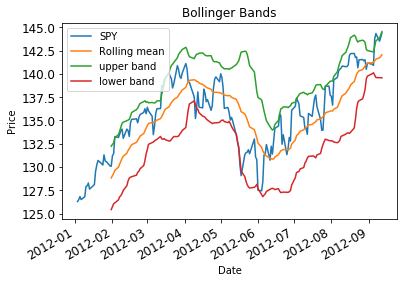

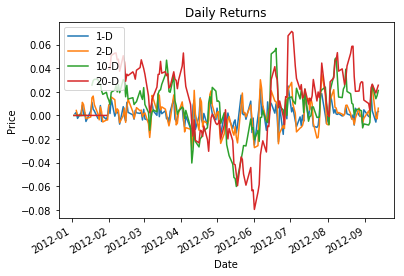

               SPY       UB       LB    1-D    2-D   10-D   20-D
2012-02-03  133.26  133.135    0.000  0.014  0.016  0.020  0.051
2012-03-13  138.73  137.837    0.000  0.018  0.018  0.018  0.035
2012-03-14  138.58  138.342    0.000 -0.001  0.017  0.021  0.035
2012-03-15  139.38  138.884    0.000  0.006  0.005  0.022  0.046
2012-03-16  139.58  139.481    0.000  0.001  0.007  0.026  0.036
2012-04-10  135.20    0.000  136.710 -0.017 -0.028 -0.040 -0.008
2012-05-14  133.42    0.000  133.525 -0.011 -0.014 -0.041 -0.021
2012-05-15  132.65    0.000  132.752 -0.006 -0.017 -0.053 -0.041
2012-05-17  130.19    0.000  130.815 -0.015 -0.019 -0.060 -0.050
2012-05-18  129.07    0.000  129.544 -0.009 -0.023 -0.053 -0.060
2012-06-01  127.50    0.000  127.668 -0.025 -0.027 -0.021 -0.080
2012-07-03  137.41  137.311    0.000  0.007  0.010  0.013  0.070
2012-07-27  138.68  138.650    0.000  0.018  0.035  0.022  0.044
2012-09-06  143.77  142.934    0.000  0.020  0.019  0.014  0.023
2012-09-07  144.33  143.5

In [2]:
"""Bollinger Bands."""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def symbol_to_path(symbol, base_dir="C:\\Users\\ppadayac\\"):    #"C:\\Users\\ppadayac\\"
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))


def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')

    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Adj Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        df = df.join(df_temp)
        if symbol == 'SPY':  # drop dates SPY did not trade
            df = df.dropna(subset=["SPY"])

    return df



def get_rolling_mean(values, window):
    """Return rolling mean of given values, using specified window size."""
    #return pd.rolling_mean(values, window=window)
    return pd.Series(values).rolling(window=window).mean()


def get_rolling_std(values, window):
    """Return rolling standard deviation of given values, using specified window size."""
    # TODO: Compute and return rolling standard deviation
    #return pd.rolling_std(values,window=window)
    return pd.Series(values).rolling(window=window).std()

def get_bollinger_bands(rm, rstd):
    """Return upper and lower Bollinger Bands."""
    upper_band = rm + rstd * 2
    lower_band = rm - rstd * 2
    return upper_band, lower_band


def compute_daily_returns(df,n=1):
    """Compute and return the daily return values."""
    df_daily_ret = (df/df.shift(n)) -1
    # Note: Returned DataFrame must have the same number of rows
    #df_daily_ret.ix[0,:] = 0
    df_daily_ret.loc[df_daily_ret.index[0:(n-1)],:]= 0
    return df_daily_ret


def test_run():
    # Read data
    dates = pd.date_range('2012-01-01', '2012-12-31')
    symbols = ['SPY']
    df = get_data(symbols, dates)

    # Compute Bollinger Bands
    # 1. Compute rolling mean
    rm_SPY = get_rolling_mean(df['SPY'], window=20)

    rstd_SPY = get_rolling_std(df['SPY'], window=20)

    # 3. Compute upper and lower bands
    upper_band, lower_band = get_bollinger_bands(rm_SPY, rstd_SPY)

    
    # Compute daily returns
    day_1_returns = compute_daily_returns(df,1)
    days_2_returns = compute_daily_returns(df,2)
    days_10_returns = compute_daily_returns(df,10)
    days_20_returns = compute_daily_returns(df,20)
    
    # Plot raw SPY values, rolling mean and Bollinger Bands
    ax = df['SPY'].plot(title="Bollinger Bands", label='SPY', fontsize=12)
    rm_SPY.plot(label='Rolling mean', ax=ax)
    upper_band.plot(label='upper band', ax=ax)
    lower_band.plot(label='lower band', ax=ax)

    
    day_1_returns.rename(columns={'SPY': '1-D'}, inplace=True)
    days_2_returns.rename(columns={'SPY': '2-D'}, inplace=True)
    days_10_returns.rename(columns={'SPY': '10-D'}, inplace=True)
    days_20_returns.rename(columns={'SPY': '20-D'}, inplace=True)
    
    ay = day_1_returns.plot(title="Daily Returns", label='Daily Returns')
    days_2_returns.plot(label='2-D Return', ax=ay)
    days_10_returns.plot(label='10-D Return', ax=ay)
    days_20_returns.plot(label='20-D Return', ax=ay)
    
    ay.set_xlabel("Date")
    ay.set_ylabel("Price")
    ay.legend(loc='upper left')
    
    # Add axis labels and legend
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend(loc='upper left')
    plt.show()
    upper_band = upper_band.dropna()
    lower_band = lower_band.dropna()
    upper_band = upper_band.to_frame('UB')
    lower_band = lower_band.to_frame('LB')

    #Main Logic
    df = df.join(upper_band,how='inner')
    df = df.join(lower_band,how='inner')
    df['UB'] = np.where(df['UB'] > df['SPY'],0,df['UB'])
    df['LB'] = np.where(df['LB'] < df['SPY'],0,df['LB'])
    df_t1 = df[['UB','LB']].copy()
    df_t1 = df_t1.loc[(df_t1 != 0).any(axis=1)]
    df = df[['SPY']].copy()
    df = df.join(df_t1,how='inner')
    df = df.join(day_1_returns,how='inner')
    df = df.join(days_2_returns,how='inner')
    df = df.join(days_10_returns,how='inner')
    df = df.join(days_20_returns,how='inner')
    print(df.round(3))
    
if __name__ == "__main__":
    test_run()